In [21]:
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
class FNNClassifier(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.Linear(512,output_dim)
        )
    def forward(self,x):
        logits = self.linear_relu_stack(x)
        return logits


In [3]:
adata = sc.read_h5ad("./data/original_intestine.h5ad")
adata

AnnData object with n_obs × n_vars = 414406 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'sample_id', 'project_id', 'sample_type', 'tissue', 'anatomical_site', 'disease', 'platform', 'age_group', 'cell_sorting', 'treatment', 'subject_id', 'age', 'gender', 'rna_source', 'other_metadata'
    var: 'gene'
    obsm: 'X_pca', 'X_umap'

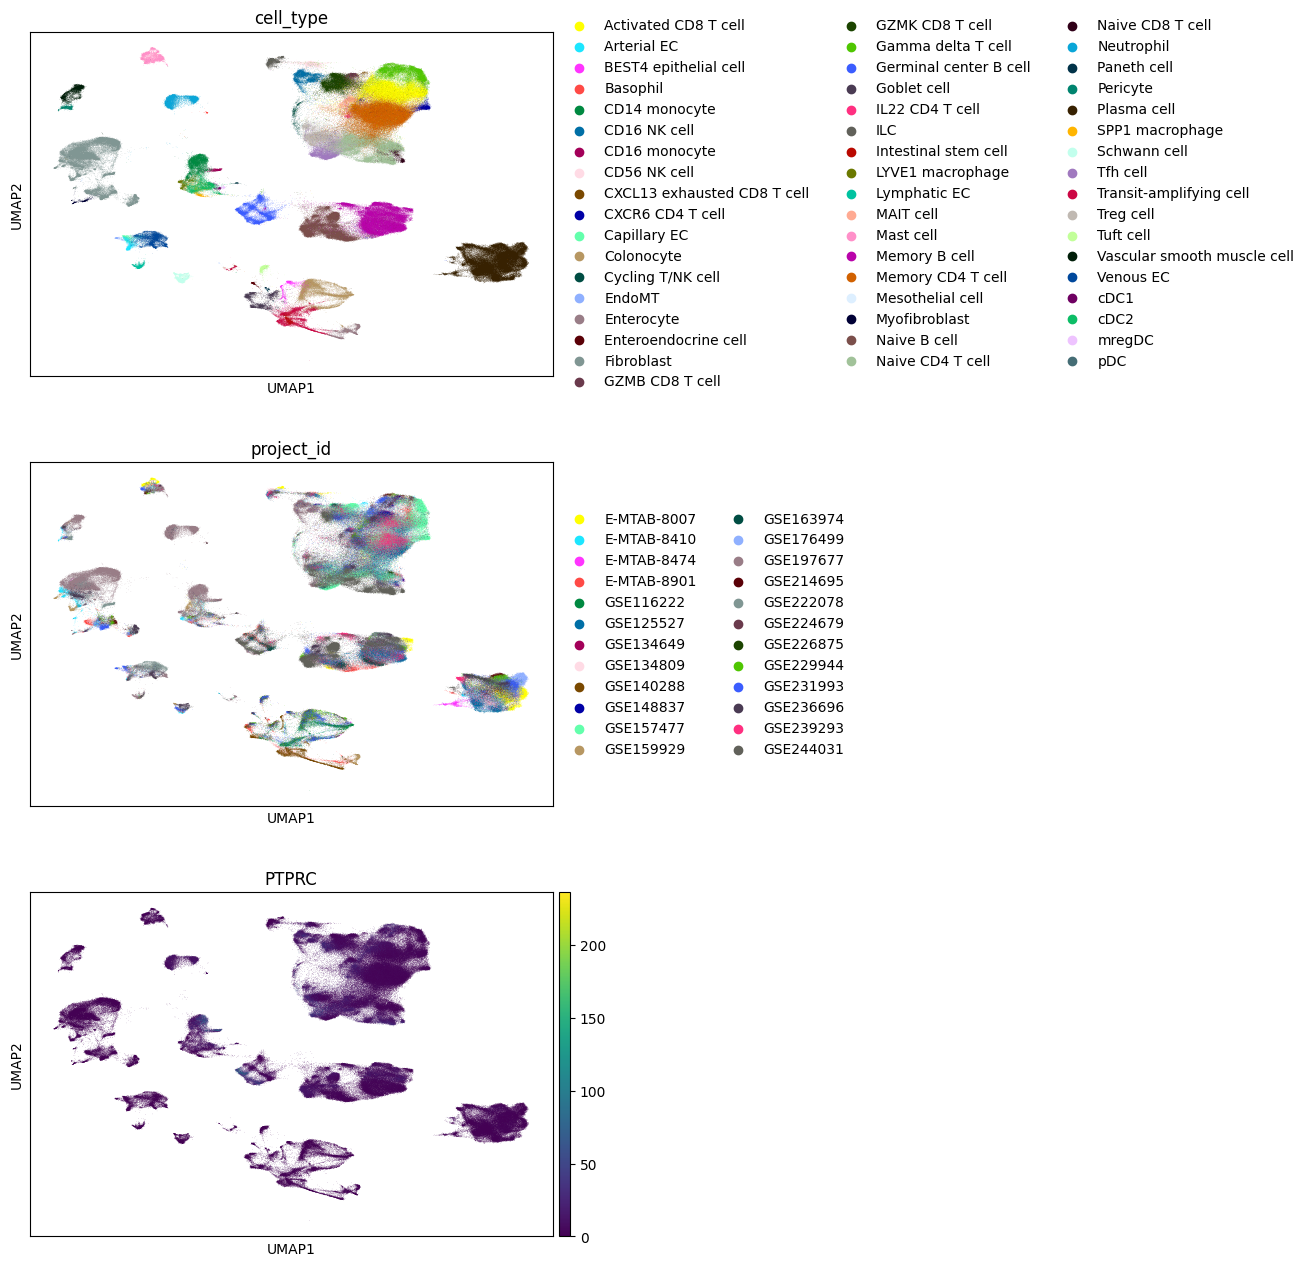

In [6]:
sc.pl.umap(adata,color=['cell_type','project_id','PTPRC'], palette=sc.pl.palettes.default_102,ncols=1)

In [10]:
cell_type_counts = adata.obs["cell_type"].value_counts()
selected_cells = []
for cell_type, count in cell_type_counts.items():
    cell_indices = adata.obs[adata.obs['cell_type'] == cell_type].index
    if len(cell_indices) > 1000:
        sampled_indices = np.random.choice(cell_indices, size=1000,replace=False)
    else:
        sampled_indices = cell_indices
    selected_cells.extend(sampled_indices)

adata_subset = adata[selected_cells]
adata_subset

View of AnnData object with n_obs × n_vars = 44084 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'sample_id', 'project_id', 'sample_type', 'tissue', 'anatomical_site', 'disease', 'platform', 'age_group', 'cell_sorting', 'treatment', 'subject_id', 'age', 'gender', 'rna_source', 'other_metadata'
    var: 'gene'
    obsm: 'X_pca', 'X_umap'

In [11]:
adata_subset.layers['counts'] = adata_subset.X.copy()
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)
adata_subset.layers["data"] = adata_subset.X.copy()
sc.pp.highly_variable_genes(adata_subset, flavor="seurat", n_top_genes=2000)
sc.pp.scale(adata_subset)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18040\2860626422.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers['counts'] = adata_subset.X.copy()


In [15]:
le = LabelEncoder()
y = adata_subset.obs['cell_type'].values
le.inverse_transform(le.fit_transform(y))

array(['Plasma cell', 'Plasma cell', 'Plasma cell', ...,
       'Mesothelial cell', 'Mesothelial cell', 'Mesothelial cell'],
      dtype=object)

In [30]:
highly_variable_genes = adata_subset.var[adata_subset.var['highly_variable']].index
X = adata_subset[:, highly_variable_genes].X
y = adata_subset.obs['cell_type'].values
le = LabelEncoder()
y = le.fit_transform(y)
# le.transorm can 
X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
# 将数据拆分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# 定义数据加载器
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
input_dim = X_train.shape[1]
output_dim = len(le.classes_)

model = FNNClassifier(input_dim, output_dim).to(device)

criterion = nn. CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
epochs = 10

for epoch in range(epochs):
    model.train() # 切换到训练模式
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", ncols=100):
        # 将数据传递到GPU/CPU
        inputs, labels = inputs.to(device), labels.to(device)
        # 清除梯度
        optimizer.zero_grad()
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # 反向传播和优化
        loss.backward()
        optimizer.step()

        # 计算损失
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")


Epoch 1/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 412.65it/s]


Epoch 1/10, Loss: 0.6455, Accuracy: 81.21%


Epoch 2/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 540.65it/s]


Epoch 2/10, Loss: 0.3833, Accuracy: 88.95%


Epoch 3/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 529.34it/s]


Epoch 3/10, Loss: 0.5963, Accuracy: 89.92%


Epoch 4/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 542.79it/s]


Epoch 4/10, Loss: 0.5206, Accuracy: 92.24%


Epoch 5/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 537.58it/s]


Epoch 5/10, Loss: 0.4334, Accuracy: 94.02%


Epoch 6/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 536.50it/s]


Epoch 6/10, Loss: 0.2356, Accuracy: 96.06%


Epoch 7/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 547.49it/s]


Epoch 7/10, Loss: 0.2053, Accuracy: 96.65%


Epoch 8/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 531.79it/s]


Epoch 8/10, Loss: 0.1587, Accuracy: 97.04%


Epoch 9/10: 100%|████████████████████████████████████████████████| 552/552 [00:01<00:00, 545.18it/s]


Epoch 9/10, Loss: 0.1062, Accuracy: 97.79%


Epoch 10/10: 100%|███████████████████████████████████████████████| 552/552 [00:00<00:00, 557.62it/s]

Epoch 10/10, Loss: 0.0869, Accuracy: 98.28%


In [34]:
# 测试模式
model.eval() # 切换到评估模式

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct/total:.2f}%")

Test Accuracy: 84.06%
